### Step 1: Import Libraries and Setup

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import time
import torchvision # Import torchvision

# Check if a GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Step 2: Load and Prepare the MNIST Dataset


In [3]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Download and load the data
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



100%|██████████| 170M/170M [00:15<00:00, 11.0MB/s]


# print few random images

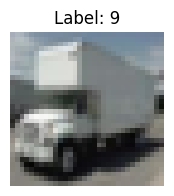

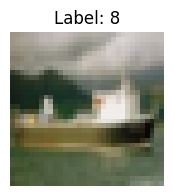

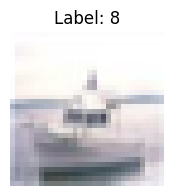

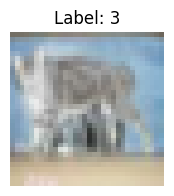

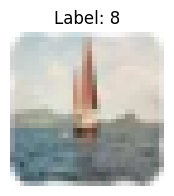

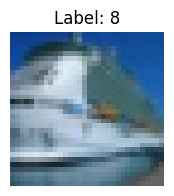

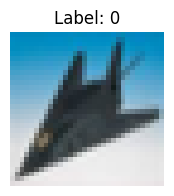

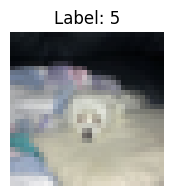

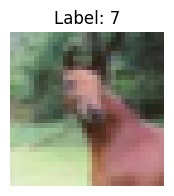

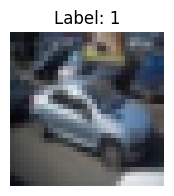

In [ ]:
# Function to show an image with its label
def imshow_with_label(img, label):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(2, 2)) # Set a smaller figure size
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Label: {label}")
    plt.axis('off') # Hide axes for cleaner look
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images with their labels
for i in range(10):  # Display the first 10 images individually
    imshow_with_label(images[i], labels[i].item())

Number of unique labels: 10
Number of images per label:
Label 0: 5000
Label 1: 5000
Label 2: 5000
Label 3: 5000
Label 4: 5000
Label 5: 5000
Label 6: 5000
Label 7: 5000
Label 8: 5000
Label 9: 5000


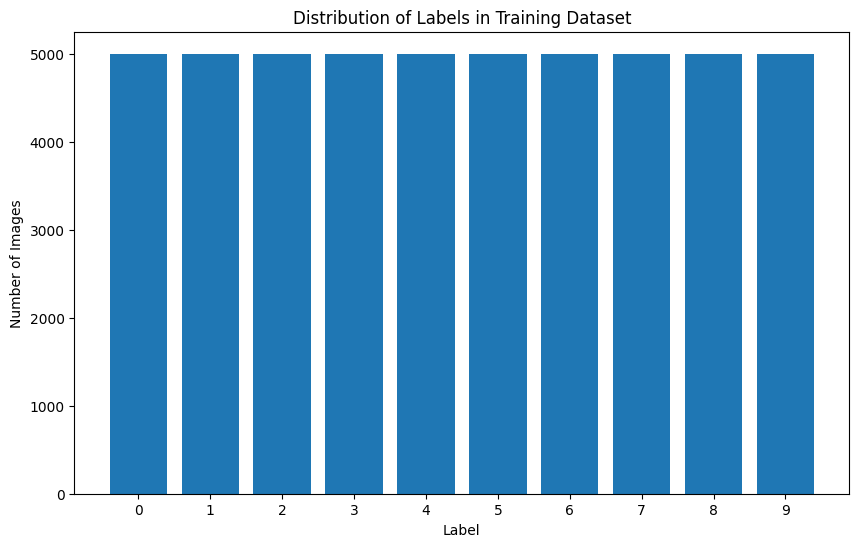

In [ ]:
# Get all labels from the training dataset
train_labels = [label for _, label in train_dataset]

# Find unique labels and their counts
unique_labels, label_counts = np.unique(train_labels, return_counts=True)

# Print the number of unique labels
print(f"Number of unique labels: {len(unique_labels)}")

# Print the number of images for each label
print("Number of images per label:")
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count}")

# Plot a bar chart of label counts
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, label_counts)
plt.xlabel("Label")
plt.ylabel("Number of Images")
plt.title("Distribution of Labels in Training Dataset")
plt.xticks(unique_labels)
plt.show()

In [ ]:
# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print the shape of the image tensor
# The shape is typically (batch_size, channels, height, width)
print("Shape of image tensor:", images.shape)

# The dimensions of each image are (channels, height, width)
print("Dimensions of each image: (channels, height, width):", images.shape[1:])

Shape of image tensor: torch.Size([128, 3, 32, 32])
Dimensions of each image: (channels, height, width): torch.Size([3, 32, 32])


## Step 3: Build a Flexible CNN Model

Here, we define our `SimpleCNN` class. This architecture is powerful because it's **dynamic**. We can specify any integer `depth` and choose from several activation functions.

**Key Components:**
- **`nn.Conv2d`**: The core convolutional layer that learns features.
- **`nn.BatchNorm2d`**: Normalizes the activations from the convolutional layer. This stabilizes the network, prevents issues like vanishing/exploding gradients, and helps the model train faster and more reliably.
- **Activation Function**: Introduces non-linearity, allowing the model to learn complex patterns.
- **`nn.MaxPool2d`**: Downsamples the feature map, reducing its spatial dimensions. This makes the model more efficient and helps it learn features that are robust to small translations in the input image.
- **`nn.Sequential`**: A container that chains our layers together, making the forward pass clean and simple.
- **`nn.Linear`**: A standard fully connected layer for the final classification.

In [9]:
class SimpleCNN(nn.Module):
    # This class defines a flexible Convolutional Neural Network.
    # You can change its depth and activation function when you create it.

    def __init__(self, activation='relu', depth=2,dropout_p=0.0): #dropout_p =0.0 means no dropout
        """
        This is the constructor method. It sets up all the layers of the network.
        Args:
            activation (str): The name of the activation function to use ('relu', 'leakyrelu', 'tanh').
            depth (int): The number of convolutional blocks in the network.
        """
        # This line is essential. It calls the constructor of the parent class (nn.Module),
        # which is necessary for PyTorch to manage the model's layers and parameters.
        super(SimpleCNN, self).__init__()

        # --- 1. Choose the Activation Function ---
        # A dictionary is used to map the string name of an activation function
        # to its actual PyTorch layer object. This makes the code clean and easy to extend.
        activations = {
            'relu': nn.ReLU(),
            'leakyrelu': nn.LeakyReLU(0.1),
            'tanh': nn.Tanh()
        }
        # Look up the activation object from the dictionary based on the 'activation' argument
        # and store it as an attribute of this class.
        self.act = activations[activation]

        # --- 2. Dynamically Build the Convolutional Layers ---
        # We'll build the convolutional part of the network in a loop.

        # Create an empty list to hold the layers for our convolutional blocks.
        layers = []
        # Initialize 'in_channels' to 1 because the input MNIST images are grayscale (one channel).
        # This variable will be updated in each iteration of the loop.
        in_channels = 3
        layers.append(nn.Conv2d(in_channels,32,kernel_size=3,padding=1))
        layers.append(nn.BatchNorm2d(32))
        layers.append(nn.LeakyReLU())
        layers.append(nn.MaxPool2d(2,2))
        layers.append(nn.Dropout(0.25))

        layers.append(nn.Conv2d(32,64,kernel_size=3,padding=1 ))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.LeakyReLU())
        layers.append(nn.Dropout(0.25))

        layers.append(nn.Conv2d(64,128,kernel_size=3,padding=1 ))
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.LeakyReLU())
        layers.append(nn.MaxPool2d(2,2))
        layers.append(nn.Dropout(0.25))

        layers.append(nn.Conv2d(128,128,kernel_size=3,padding=1))
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.LeakyReLU())
        layers.append(nn.Dropout(0.25))

        layers.append(nn.Conv2d(128,128,kernel_size=3,padding=1 ))
        layers.append(nn.BatchNorm2d(128))
        layers.append(nn.LeakyReLU())
        layers.append(nn.MaxPool2d(2,2))
        layers.append(nn.Dropout(0.25))

        self.conv_layers = nn.Sequential(*layers)

        fc_layers = []

        fc_layers.append(nn.Flatten())
        fc_layers.append(nn.Linear(128*4*4,512))
        fc_layers.append(nn.LeakyReLU())
        fc_layers.append(nn.Dropout(0.5))
        fc_layers.append(nn.Linear(512,256))
        fc_layers.append(nn.LeakyReLU())
        fc_layers.append(nn.Dropout(0.4))

        fc_layers.append(nn.Linear(256,84))
        fc_layers.append(nn.LeakyReLU())
        fc_layers.append(nn.Dropout(0.3))

        fc_layers.append(nn.Linear(84,10))
        self.fc = nn.Sequential(*fc_layers)

        '''

        # This loop runs 'depth' times. Each iteration adds one complete convolutional block.
        for i in range(depth):
            # Calculate the number of output channels (filters) for the current layer.
            # The formula 16 * (2**i) doubles the channels at each layer:
            # Layer 0 (i=0): 16 * 1 = 16 channels
            # Layer 1 (i=1): 16 * 2 = 32 channels
            # Layer 2 (i=2): 16 * 4 = 64 channels ...and so on.
            out_channels = 16 * (2**i)

            # --- Add a complete convolutional block to the 'layers' list ---
            # a) Convolutional Layer: Applies filters to the input.
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            # b) Batch Normalization: Stabilizes training and helps the model learn faster.
            layers.append(nn.BatchNorm2d(out_channels))
            # c) Activation Function: Introduces non-linearity.
            layers.append(self.act)
            # d) Max Pooling: Downsamples the feature map, reducing its height and width by half.
            layers.append(nn.MaxPool2d(2))

            layers.append(nn.Dropout(p=dropout_p))


            # Update 'in_channels' for the *next* iteration of the loop.
            # The output channels of this layer become the input channels for the next one.
            in_channels = out_channels

        # --- 3. Wrap the Convolutional Layers in nn.Sequential ---
        # The * operator unpacks the 'layers' list.
        # nn.Sequential creates a single module that passes data through each layer in order.
        self.conv_layers = nn.Sequential(*layers)

        # --- 4. Define the Final Fully Connected (Classifier) Layer ---

        # Automatically calculate the size of the feature map after all conv/pool layers.
        # The initial image size is 28x28. Each MaxPool2d layer halves the dimensions.
        final_img_size = 32 // (2**depth)
        # The total number of features to be fed into the linear layer is:
        # (last number of channels) * (final height) * (final width)
        fc_input_features = in_channels * final_img_size * final_img_size

        # Create the final linear layer. It takes the flattened features and outputs 10 scores,
        # one for each digit class (0-9).
        self.fc = nn.Linear(fc_input_features, 10)

'''
    def forward(self, x):
        """
        This method defines the forward pass of the network.
        It specifies how input data 'x' flows through the layers.
        Args:
            x (torch.Tensor): The input data (a batch of images).
        """
        # 1. Pass the input 'x' through all the convolutional blocks.
        x = self.conv_layers(x)

        # 2. Flatten the output from the convolutional layers.
        # The output is a 4D tensor: [batch_size, channels, height, width].
        # We flatten it into a 2D tensor: [batch_size, total_features]
        # so it can be processed by the linear layer. The '1' means we keep the batch dimension.
        x = torch.flatten(x, 1)

        # 3. Pass the flattened tensor through the final fully connected layer.
        # This produces the raw output scores (logits) for each class.
        x = self.fc(x)

        # 4. Return the final scores.
        return x


## Step 4: Inspect the Model with `torchsummary`

Before training, let's use torchsummary to understand what we've built. We'll create a model with depth=2 and look at its structure.

**How to Read the Summary:**
- **Layer (type)**: The name and type of the layer.
- **Output Shape**: The shape of the tensor after passing through that layer. [batch_size, channels, height, width].
- **Param #**: The number of trainable parameters in that layer.

**Intuition:** Watch how the dimensions change. The Conv2d and BatchNorm2d layers increase the number of channels (from 1 to 16, then 32), while MaxPool2d halves the height and width (from 28x28 to 14x14, then 7x7). This process transforms the spatial information into a rich set of features.

In [ ]:
# Create a sample model to inspect (depth=2, relu activation)
model_to_inspect = SimpleCNN(activation='relu', depth=2).to(device)

# The input size is (channels, height, width)
summary(model_to_inspect, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
           Dropout-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
         LeakyReLU-8           [-1, 64, 16, 16]               0
           Dropout-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        LeakyReLU-12          [-1, 128, 16, 16]               0
        MaxPool2d-13            [-1, 128, 8, 8]               0
          Dropout-14            [-1, 12

## Step 5: Define Training and Experiment Runner

We'll create a single, reusable function `run_experiment` that will:
1.  Instantiate a model with a given depth and activation.
2.  Define the loss function and optimizer.
3.  Train the model for a few epochs.
4.  Evaluate it on the test set.
5.  Return the final accuracy and training time.

In [7]:
def run_experiment(depth, activation, dropout = 0.0, epochs=4):
    """Initializes, trains, and tests a model with given hyperparameters."""
    print(f"--- Starting Experiment: Depth={depth}, Activation={activation} ---")

    # 1. Create Model
    model = SimpleCNN(activation=activation, depth=depth, dropout_p=dropout).to(device)

    # 2. Define Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = time.time()

    # 3. Train the model
    model.train()
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    training_time = time.time() - start_time
    print(f'Finished Training in {training_time:.2f}s')

    # 4. Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test images: {accuracy:.2f} %\n')

    return {'depth': depth, 'activation': activation, 'accuracy': accuracy, 'time': training_time}

## Step 6: Run the Experiments!

In [5]:
results = []


In [ ]:

# --- Part A: Comparing Depth (with ReLU) ---
results.append(run_experiment(depth=1, activation='relu'))
results.append(run_experiment(depth=2, activation='relu'))
results.append(run_experiment(depth=3, activation='relu'))

# --- Part B: Comparing Activation Functions (with Depth=2) ---
# We already ran ReLU with depth=2, so we just need the others.
results.append(run_experiment(depth=2, activation='leakyrelu'))
results.append(run_experiment(depth=2, activation='tanh'))

--- Starting Experiment: Depth=1, Activation=relu ---
Epoch [1/4], Loss: 1.4423
Epoch [2/4], Loss: 1.1642
Epoch [3/4], Loss: 1.0682
Epoch [4/4], Loss: 1.1128
Finished Training in 152.22s
Accuracy on test images: 61.76 %

--- Starting Experiment: Depth=2, Activation=relu ---
Epoch [1/4], Loss: 1.1111
Epoch [2/4], Loss: 0.8982
Epoch [3/4], Loss: 1.1092
Epoch [4/4], Loss: 0.9422
Finished Training in 229.55s
Accuracy on test images: 67.41 %

--- Starting Experiment: Depth=3, Activation=relu ---
Epoch [1/4], Loss: 1.1879
Epoch [2/4], Loss: 0.9035
Epoch [3/4], Loss: 0.8033
Epoch [4/4], Loss: 0.7697
Finished Training in 270.71s
Accuracy on test images: 70.71 %

--- Starting Experiment: Depth=2, Activation=leakyrelu ---
Epoch [1/4], Loss: 0.9997
Epoch [2/4], Loss: 0.8396
Epoch [3/4], Loss: 0.8468
Epoch [4/4], Loss: 0.9113
Finished Training in 225.08s
Accuracy on test images: 67.00 %

--- Starting Experiment: Depth=2, Activation=tanh ---
Epoch [1/4], Loss: 1.0163
Epoch [2/4], Loss: 1.2011
Epoch

In [ ]:
results.append(run_experiment(depth=5, activation='relu'))


--- Starting Experiment: Depth=5, Activation=relu ---
Epoch [1/4], Loss: 1.0118
Epoch [2/4], Loss: 0.9394
Epoch [3/4], Loss: 0.5435
Epoch [4/4], Loss: 0.4855
Finished Training in 418.73s
Accuracy on test images: 73.76 %



In [11]:
results.append(run_experiment(depth=5, activation='relu',dropout=0.5, epochs=30))


--- Starting Experiment: Depth=5, Activation=relu ---
Epoch [1/30], Loss: 1.3051
Epoch [2/30], Loss: 0.9179
Epoch [3/30], Loss: 0.9701
Epoch [4/30], Loss: 0.9925
Epoch [5/30], Loss: 0.7235
Epoch [6/30], Loss: 0.7444
Epoch [7/30], Loss: 0.7128
Epoch [8/30], Loss: 0.7408
Epoch [9/30], Loss: 0.8467
Epoch [10/30], Loss: 0.6732
Epoch [11/30], Loss: 0.5700
Epoch [12/30], Loss: 0.6404
Epoch [13/30], Loss: 0.8578
Epoch [14/30], Loss: 0.6277
Epoch [15/30], Loss: 0.5445
Epoch [16/30], Loss: 0.3568
Epoch [17/30], Loss: 0.5883
Epoch [18/30], Loss: 0.5583
Epoch [19/30], Loss: 0.5528
Epoch [20/30], Loss: 0.4646
Epoch [21/30], Loss: 0.4030
Epoch [22/30], Loss: 0.4300
Epoch [23/30], Loss: 0.4172
Epoch [24/30], Loss: 0.4991
Epoch [25/30], Loss: 0.5167
Epoch [26/30], Loss: 0.3840
Epoch [27/30], Loss: 0.3594
Epoch [28/30], Loss: 0.4314
Epoch [29/30], Loss: 0.4592
Epoch [30/30], Loss: 0.5300
Finished Training in 383.76s
Accuracy on test images: 84.18 %



In [ ]:
print("--- Final Experiment Results ---")
print("-" * 40)
print(f"{'Depth':<10} {'Activation':<15} {'Accuracy (%)':<15} {'Time (s)':<10}")
print("-" * 40)
for res in results:
    print(f"{res['depth']:<10} {res['activation']:<15} {res['accuracy']:<15.2f} {res['time']:<10.2f}")
print("-" * 40)

--- Final Experiment Results ---
----------------------------------------
Depth      Activation      Accuracy (%)    Time (s)  
----------------------------------------
1          relu            61.76           152.22    
2          relu            67.41           229.55    
3          relu            70.71           270.71    
2          leakyrelu       67.00           225.08    
2          tanh            65.29           231.53    
5          relu            73.76           418.73    
----------------------------------------
